# Rolling ball filter

- https://media.nature.com/original/nature-assets/srep/2016/160725/srep30179/extref/srep30179-s1.pdf
- https://github.com/imagej/imagej1/blob/master/ij/plugin/filter/BackgroundSubtracter.java
- http://ieeexplore.ieee.org/document/1654163/?reload=true

https://plot.ly/python/alpha-shapes/
>In a family of alpha shapes, the parameter α controls the level of detail of the associated alpha shape. If α decreases to zero, the corresponding alpha shape degenerates to the point set, S, while if it tends to infinity the alpha shape tends to the convex hull of the set S.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial

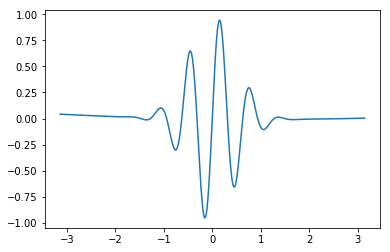

In [2]:
x= np.linspace(-1 * np.pi, 1 * np.pi, 256)
y = np.sin(10 * x)
y *= np.exp(-2 * x**2)
y += np.poly1d(np.random.randn(3))(x) * 0.01
plt.plot(x, y)

In [3]:
d = spatial.Delaunay(np.array((x, y)).T)

In [4]:
def sq_norm(v): #squared norm 
    return np.linalg.norm(v)**2

Compute the circumcenter and circumradius of a triangle (see their definitions [here](https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations)):

In [5]:
def circumcircle(points,simplex):
    """Get the circumcenter and circum radius of all the simplices, works for 2D only
    
    Compute the circumcenter and circumradius of a triangle (see their definitions
    https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations)"""
    A=[points[simplex[k]] for k in range(3)]
    M=[[1.0]*4]
    M+=[[sq_norm(A[k]), A[k][0], A[k][1], 1.0 ] for k in range(3)] 
    M=np.asarray(M, dtype=float) 
    S=np.array([0.5*np.linalg.det(M[1:,[0,2,3]]), -0.5*np.linalg.det(M[1:,[0,1,3]])]) 
    a=np.linalg.det(M[1:, 1:]) 
    b=np.linalg.det(M[1:, [0,1,2]]) 
    return S/a,  np.array([np.sqrt(b/a+sq_norm(S)/a**2)]) #center=S/a, radius=np.sqrt(b/a+sq_norm(S)/a**2)

Filter the Delaunay triangulation to get the $\alpha$-complex:

In [6]:
def get_alpha_complex(alpha, points, simplices):
    # find the centers and radii of all circumcircles
    centers, radii = np.array([circumcircle(points, s) for s in simplices]).T
    # convert centers to array
    centers = np.vstack(centers)
    # find which points you want to keep
    to_keep = radii > alpha
    alpha_complex = points[simplices[to_keep]]
    # calculate where the center of the circle lies with respect to the vertices
    above_right = p > centers[to_keep][:, None]
    return alpha_complex, above_right

In [7]:
a, b = roll_balls(.25, d.points, d.simplices)

In [8]:
# calculate the ball rolling from the left
pr = b.sum(1)[:,0] > 1
# calculate the ball rolling from below
pa = b.sum(1)[:,1] > 1

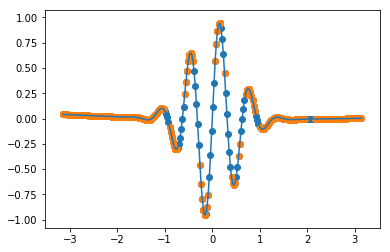

In [12]:

fig, ax = plt.subplots()
X, Y = a[pr].reshape(-1, 2).T
ax.scatter(x, y)
ax.scatter(X, Y)
ax.plot(x, y)

(193,)

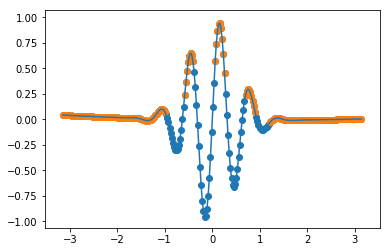

In [18]:
# the complement of rolling above is below
fig, ax = plt.subplots()
X, Y = np.unique(a[~pa].reshape(-1, 2), axis=0).T
ax.scatter(x, y)
ax.scatter(X, Y)
ax.plot(x, y)
X.shape

In [11]:
import scipy.interpolate

In [35]:
def rolling_ball_filter(data, ball_radius, roll_along=-1, top=True,
                        interpolator=scipy.interpolate.interp1d, **kwargs):
    """Rolling ball filter
    
    Parameters
    ----------
    data : ndarray (n, d)
        Array of data points, assumed xyz ordering
    ball_radius : float
        The size of the ball to roll
    roll_along : int
        The axis perpendicular to the roll direction
    top : bool
        Top or bottom
    interpolator : callable
        needs to take two arrays and return a callable
    kwargs : for interpolator
    
    Returns
    -------
    data : ndarray (n, d)
        Smoothed data"""
    n, d = data.shape
    tri = spatial.Delaunay(data)
    alpha_complex, above_right = roll_balls(ball_radius, tri.points, tri.simplices)
    # calculate the ball rolling from the right
    # sum along vertices and direction, determine if more than one vertex is
    kept_points = above_right.sum(1)[:, roll_along] > 1
    if not top:
        kept_points = ~kept_points
    d_kept = np.unique(alpha_complex[kept_points].reshape(-1, d), axis=0)
    x, y = data.T
    X, Y = d_kept.T
    interp = interpolator(X, Y, **kwargs)
    return x, interp(x)

(256,)

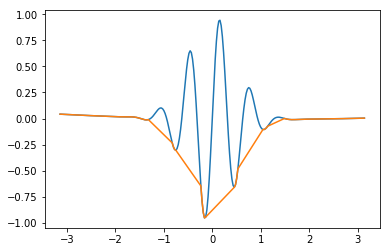

In [52]:
X, Y = rolling_ball_filter(np.array((x, y)).T, 0.5, kind=1)

# the complement of rolling above is below
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(X, Y)
X.shape